The main purpose of this file is to use our trained CBA-Net to predict ECG waveforms, and to output the corresponding relevant lead plots, along with the model's confidence scores and diagnostic predictions for each condition.

In [15]:
!pip install neurokit2


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import ecg_plot
import os
from collections import Counter,defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
import neurokit2 as nk

ECG-plot functions

In [17]:
def plot_combined_ecg(ecg, sample_rate, title):
    """
    Plot a combined 12-lead ECG layout from a PTB-XL ECG sample.
    This function reorders the ECG segments to match a 4-row print format and overlays lead labels.

    Parameters:
    - ecg: numpy array (n_samples x 12), ECG signal
    - fields: metadata dictionary from wfdb.rdsamp  ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    - lead_names: list of original lead names
    - sample_rate: sampling rate of the ECG signal (e.g., 100 or 500 Hz)
    """

    # Get the total number of samples
    n = ecg.shape[0]

    # Quarter marks to split ECG signal into 4 equal time segments
    q1, q2, q3 = n // 4, n // 2, 3 * n // 4

    # Create new leads for each row of the standard layout
    # First row: Lead I, aVR, V1, V4
    lead_I_new = np.concatenate([ecg[0:q1, 0], ecg[q1:q2, 3], ecg[q2:q3, 6], ecg[q3:n, 9]])

    # Second row: Lead II, aVL, V2, V5
    lead_II_new = np.concatenate([ecg[0:q1, 1], ecg[q1:q2, 4], ecg[q2:q3, 7], ecg[q3:n, 10]])

    # Third row: Lead III, aVF, V3, V6
    lead_III_new = np.concatenate([ecg[0:q1, 2], ecg[q1:q2, 5], ecg[q2:q3, 8], ecg[q3:n, 11]])

    # Bottom row (reference): Full Lead II
    lead_IV_new = ecg[:, 1]

    # Stack the 4 new rows (each as a separate lead)
    ecg_new = np.stack([lead_I_new, lead_II_new, lead_III_new, lead_IV_new], axis=1).transpose()

    # Define new lead labels
    lead_names_new = ['I', 'II', 'III', 'II Ref']

    # Plot ECG using ecg_plot library
    ecg_plot.plot(ecg_new, sample_rate=sample_rate, title=title, columns=1, lead_index=lead_names_new)

    # Grab axis from current figure
    ax = plt.gca()

    # Hide tick labels on vertical axis (but keep the ticks)
    ax.set_yticklabels([])

    # Format x-axis labels: only show ticks at integer seconds
    xlabels = ax.get_xticks()
    new_labels = [f"{int(x)}s" if x % 1 == 0 and x <= 10 else "" for x in xlabels]
    ax.set_xticklabels(new_labels)

    # Add annotations for the original leads contributing to each row
    ax.text(2.5, -0.75, 'aVR', fontsize=8, color='black')
    ax.text(2.5, -3.5, 'aVL', fontsize=8, color='black')
    ax.text(2.5, -6.5, 'aVF', fontsize=8, color='black')

    ax.text(5, -0.75, 'V1', fontsize=8, color='black')
    ax.text(5, -3.5, 'V2', fontsize=8, color='black')
    ax.text(5, -6.5, 'V3', fontsize=8, color='black')

    ax.text(7.5, -0.75, 'V4', fontsize=8, color='black')
    ax.text(7.5, -3.5, 'V5', fontsize=8, color='black')
    ax.text(7.5, -6.5, 'V6', fontsize=8, color='black')

    # Add display information for ECG scale and sampling
    ax.text(0.1, -10.4, f'{sample_rate} Hz   25.0 mm/s   10.0mm/mV', fontsize=10, color='black')

    # Display the plot
    ecg_plot.show()

def plot_ecg_with_grid(time, ecg_signal, title="", sampling_rate=100, highlights=None):
    plt.figure(figsize=(12, 4))
    plt.plot(time, ecg_signal, label='ECG Signal', color='black')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)

    if highlights:
        for htype, segments in highlights.items():
            for start_idx, end_idx in segments:
                if htype == 'RR':
                    plt.axvspan(time[start_idx], time[end_idx], color='blue', alpha=0.3, label='RR Interval')
                elif htype == 'Q_wave':
                    plt.axvline(time[start_idx], color='red', linestyle='--', label='Q wave (-0.2s)')
                elif htype == 'QRS':
                    plt.axvspan(time[start_idx], time[end_idx], color='green', alpha=0.4, label='QRS Complex')
                elif htype == 'PQ':
                    plt.axvspan(time[start_idx], time[end_idx], color='blue', alpha=0.4, label='P-Q Interval')
                elif htype == 'R_peak':
                    plt.axvline(time[start_idx], color='magenta', linestyle=':', label='R Peak')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.tight_layout()
    plt.show()

def generate_highlight_info_neurokit(ecg_path, sampling_rate=100, key_leads=[2], highlight_types=None):
    ecg_data = np.load(ecg_path)
    highlight_info = {}
    highlight_durations = {}

    for lead_idx in key_leads:
        if lead_idx > ecg_data.shape[0]:
            continue

        signal = ecg_data[lead_idx - 1]

        try:
            ecg_cleaned = nk.ecg_clean(signal, sampling_rate=sampling_rate)
            _, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate)
            _, delineate = nk.ecg_delineate(ecg_cleaned, rpeaks=rpeaks["ECG_R_Peaks"],
                                            sampling_rate=sampling_rate, method="cwt")

            r_locs = rpeaks["ECG_R_Peaks"]
            p_onsets = delineate["ECG_P_Onsets"]
            p_offsets = delineate["ECG_P_Offsets"]

        except Exception as e:
            print(f"Error processing lead {lead_idx}: {e}")
            continue

        lead_highlight = defaultdict(list)
        lead_durations = defaultdict(list)

        if highlight_types is None or "P_wave" in highlight_types:
            for onset, offset in zip(p_onsets, p_offsets):
                if onset is not None and offset is not None and onset < offset:
                    lead_highlight["P_wave"].append((onset, offset))
                    lead_durations["P_wave"].append((offset - onset) / sampling_rate * 1000)

        for i in range(1, len(r_locs)):
            r1, r2 = r_locs[i - 1], r_locs[i]
            r = r2
            qrs_start = max(r - int(0.04 * sampling_rate), 0)
            qrs_end = min(r + int(0.04 * sampling_rate), len(signal) - 1)
            q_wave_idx = max(r - int(0.2 * sampling_rate), 0)
            pq_start = q_wave_idx
            pq_end = qrs_start

            if highlight_types is None or 'RR' in highlight_types:
                lead_highlight['RR'].append((r1, r2))
                lead_durations['RR'].append((r2 - r1) / sampling_rate * 1000)

            if highlight_types is None or 'QRS' in highlight_types:
                lead_highlight['QRS'].append((qrs_start, qrs_end))
                lead_durations['QRS'].append((qrs_end - qrs_start) / sampling_rate * 1000)

            if highlight_types is None or 'Q_wave' in highlight_types:
                lead_highlight['Q_wave'].append((q_wave_idx, q_wave_idx))
                lead_durations['Q_wave'].append(0.0)

            if highlight_types is None or 'PQ' in highlight_types:
                lead_highlight['PQ'].append((pq_start, pq_end))
                lead_durations['PQ'].append((pq_end - pq_start) / sampling_rate * 1000)

            if highlight_types is None or 'R_peak' in highlight_types:
                lead_highlight['R_peak'].append((r, r))
                lead_durations['R_peak'].append(0.0)

        highlight_info[lead_idx] = lead_highlight
        highlight_durations[lead_idx] = dict(lead_durations)

    for lead_idx, dur_types in highlight_durations.items():
        print(f"\nLead {lead_idx} durations:")
        for htype, durations in dur_types.items():
            durations_str = ', '.join(f"{d:.1f}" for d in durations)
            print(f"  {htype} = [{durations_str}] (ms)")

    return highlight_info


def load_numpy_binary_and_plot_separate(key_lead, input_filename="ecg_data.npy", sampling_rate=100, highlight_info=None):
    try:
        loaded_ecg_data = np.load(input_filename)
        time = np.linspace(0, loaded_ecg_data.shape[1] / sampling_rate, loaded_ecg_data.shape[1], endpoint=False)

        for i in range(loaded_ecg_data.shape[0]):
            if key_lead and (i + 1) in key_lead:
                lead_highlights = highlight_info.get(i + 1, {}) if highlight_info else {}
                title = f"Lead {i+1}"
                plot_ecg_with_grid(time, loaded_ecg_data[i, :], title, sampling_rate=sampling_rate, highlights=lead_highlights)

    except Exception as e:
        print(f"Error loading or plotting: {e}")
def load_numpy_binary_and_plot_combined(input_filename="ecg_data.npy", sampling_rate=100, title="Combined 12-Lead ECG"):
    try:
        loaded_ecg_data = np.load(input_filename)
        # Transpose back to (n_samples x 12) for plot_combined_ecg
        ecg_for_combined = loaded_ecg_data.T
        plot_combined_ecg(ecg_for_combined, sampling_rate, title)

    except FileNotFoundError:
        print(f"Error: Could not find file '{input_filename}'")
    except Exception as e:
        print(f"An error occurred while loading and plotting the combined ECG: {e}")

CBA-net MODEL

In [18]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, input_dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        assert input_dim % num_heads == 0, "input_dim must be divisible by num_heads"
        self.q_proj = nn.Linear(input_dim, input_dim)
        self.k_proj = nn.Linear(input_dim, input_dim)
        self.v_proj = nn.Linear(input_dim, input_dim)
        self.out_proj = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, T, D = x.shape  # (B, T, D)
        H = self.num_heads
        d = self.head_dim

        Q = self.q_proj(x).view(B, T, H, d).transpose(1, 2)  # (B, H, T, d)
        K = self.k_proj(x).view(B, T, H, d).transpose(1, 2)
        V = self.v_proj(x).view(B, T, H, d).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (d ** 0.5)  # (B, H, T, T)
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context = torch.matmul(attn_weights, V)  # (B, H, T, d)
        context = context.transpose(1, 2).contiguous().view(B, T, D)  # (B, T, D)

        output = self.out_proj(context.mean(dim=1))  
        return output  # (B, D)
class ECGCNNBiLSTM_Attn(nn.Module):
    def __init__(self, n_classes):
        super(ECGCNNBiLSTM_Attn, self).__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)

        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=1,
                            batch_first=True, bidirectional=True)

        # Multi-Head Self-Attention
        self.mh_attention = MultiHeadSelfAttention(input_dim=128 * 2, num_heads=4)

        self.fc = nn.Linear(128 * 2, n_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = x.transpose(1, 2)         # (B, T, C)
        lstm_out, _ = self.lstm(x)    # (B, T, 256)

        x = self.mh_attention(lstm_out)  # (B, 256)
        x = self.fc(x)                  # (B, n_classes)
        return x

In [19]:
n_classes = 7

In [20]:
others = "CBA_net_model/ECG_final_model.pt"
model = ECGCNNBiLSTM_Attn(n_classes)  
model.load_state_dict(torch.load(others))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

label_map = {
    0: '1AVB',
    1: 'AFIB',
    2: 'AFLT',
    3: 'CLBBB',
    4: 'CRBBB',
    5: 'NORM',
    6: 'OTHERS'
}
def predict_ecg_npy(npy_path, threshold=0.7):
    data = np.load(npy_path)
    if data.shape == (1000, 12):
        data = data.T
    elif data.shape != (12, 1000):
        raise ValueError(f"Unexpected shape: {data.shape}")

    tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred = torch.max(probs, dim=1)
        pred = pred.item()
        confidence = confidence.item()

    if confidence < threshold:
        return "UNCERTAIN", confidence
    else:
        return label_map[pred], confidence
def test_model_performance(root_dir):
    result_list = []
    for folder in sorted(os.listdir(root_dir)):
        npy_path = os.path.join(root_dir, folder, f"{folder}.npy")
        if os.path.isfile(npy_path):
            try:
                pred_label, confidence = predict_ecg_npy(npy_path)
                print(f"{folder}: Predicted Label → {pred_label} (Confidence: {confidence:.4f})")
                result_list.append((npy_path,pred_label))
            except Exception as e:
                print(f"{folder}: Error → {e}")
        else:
            print(f"{folder}: File not found: {npy_path}")
    return result_list

Using both validation and test dataset to generate the prediction results.

In [21]:
result1 = test_model_performance("New_sample_to_test/validation")
result2 = test_model_performance("New_sample_to_test/test")

validation01: Predicted Label → NORM (Confidence: 0.9767)
validation02: Predicted Label → AFLT (Confidence: 0.9963)
validation03: Predicted Label → 1AVB (Confidence: 0.7789)
validation04: Predicted Label → AFIB (Confidence: 0.9808)
validation05: Predicted Label → CRBBB (Confidence: 0.9994)
validation06: Predicted Label → CLBBB (Confidence: 1.0000)
test01: Predicted Label → 1AVB (Confidence: 0.8615)
test02: Predicted Label → CLBBB (Confidence: 0.9979)
test03: Predicted Label → NORM (Confidence: 0.9940)
test04: Predicted Label → AFLT (Confidence: 0.9271)
test05: Predicted Label → AFIB (Confidence: 0.8588)
test06: Predicted Label → CRBBB (Confidence: 0.9972)


The main purpose of the Python function plot_key_ecg(result) is to visualize ECG waveforms based on different diagnostic results. For each ECG type, it selects the most relevant leads and generates corresponding plots, highlighting key features such as RR intervals and QRS complexes that the model focuses on. This helps in interpreting and verifying the model's predictions.

In [22]:
def plot_key_ecg(result):
    for ecg_path, ecg_label in result:
        print(f"{ecg_path} → {ecg_label}")

        if ecg_label == "AFIB":
            key_leads = [2, 7]  # Lead II, V1
            highlight_types = ["RR", "Q_wave"]
            highlights = generate_highlight_info_neurokit(
                ecg_path, sampling_rate=100,
                key_leads=key_leads, highlight_types=highlight_types
            )
            load_numpy_binary_and_plot_separate(
                key_lead=key_leads, input_filename=ecg_path,
                sampling_rate=100, highlight_info=highlights
            )

        elif ecg_label == "AFLT":
            key_leads = [2, 3, 6]  # Lead II, III, aVF
            highlight_types = ["QRS"]
            highlights = generate_highlight_info_neurokit(
                ecg_path, sampling_rate=100,
                key_leads=key_leads, highlight_types=highlight_types
            )
            load_numpy_binary_and_plot_separate(
                key_lead=key_leads, input_filename=ecg_path,
                sampling_rate=100, highlight_info=highlights
            )

        elif ecg_label == "1AVB":
            key_leads = [2]  # Lead II
            highlight_types = ["PQ", "QRS"]
            highlights = generate_highlight_info_neurokit(
                ecg_path, sampling_rate=100,
                key_leads=key_leads, highlight_types=highlight_types
            )
            load_numpy_binary_and_plot_separate(
                key_lead=key_leads, input_filename=ecg_path,
                sampling_rate=100, highlight_info=highlights
            )

        elif ecg_label == "CRBBB":
            key_leads = [7, 8]  # V1, V2
            highlight_types = ["QRS"]
            highlights = generate_highlight_info_neurokit(
                ecg_path, sampling_rate=100,
                key_leads=key_leads, highlight_types=highlight_types
            )
            load_numpy_binary_and_plot_separate(
                key_lead=key_leads, input_filename=ecg_path,
                sampling_rate=100, highlight_info=highlights
            )

        elif ecg_label == "CLBBB":
            key_leads = [1, 11, 12]  # Lead I, V5, V6
            highlight_types = ["R_peak", "QRS"]
            highlights = generate_highlight_info_neurokit(
                ecg_path, sampling_rate=100,
                key_leads=key_leads, highlight_types=highlight_types
            )
            load_numpy_binary_and_plot_separate(
                key_lead=key_leads, input_filename=ecg_path,
                sampling_rate=100, highlight_info=highlights
            )

        elif ecg_label == "NORM":
            load_numpy_binary_and_plot_combined(
                input_filename=ecg_path, title="Normal ECG (NORM)"
            )

        elif ecg_label == "OTHERS":
            print("Skipping OTHERS category.")
            continue

        else:
            print(f"Unknown label '{ecg_label}' – skipping.")

Validation dataset explanation

The neurokit2 tool performs well in identifying QRS peak points, but its performance in detecting the onset of the waves is relatively limited. As a result, the actual time intervals shown in the explanation may be slightly longer than the values visually indicated on the plots.

Blackboard_dataset/validation\validation01\validation01.npy → NORM


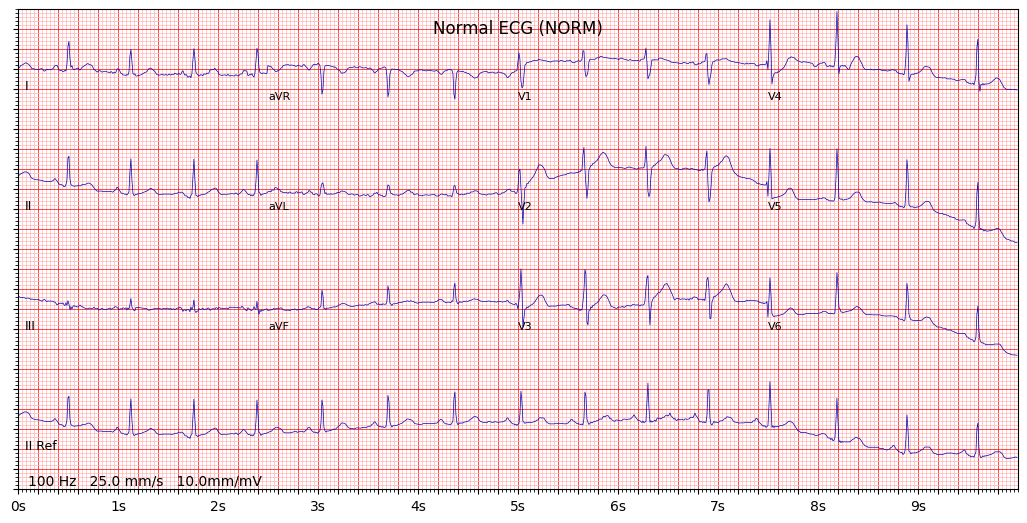

Blackboard_dataset/validation\validation02\validation02.npy → AFLT

Lead 2 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)

Lead 3 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)

Lead 6 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)


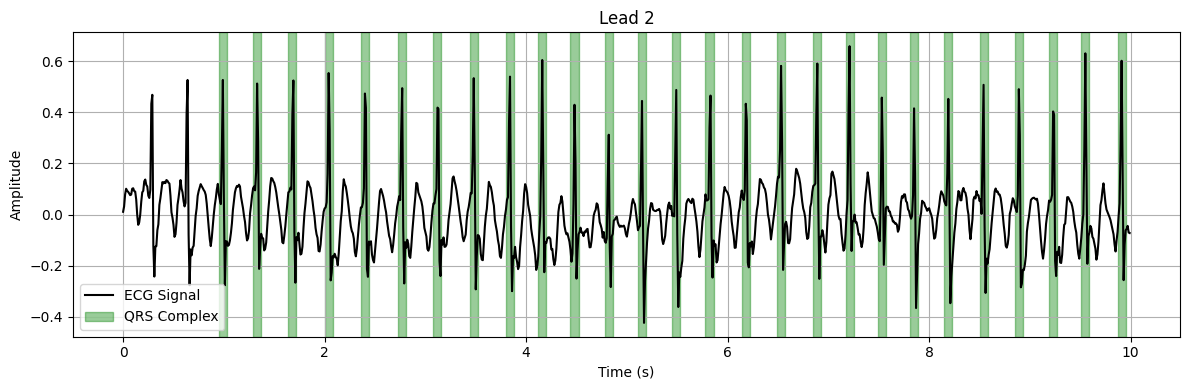

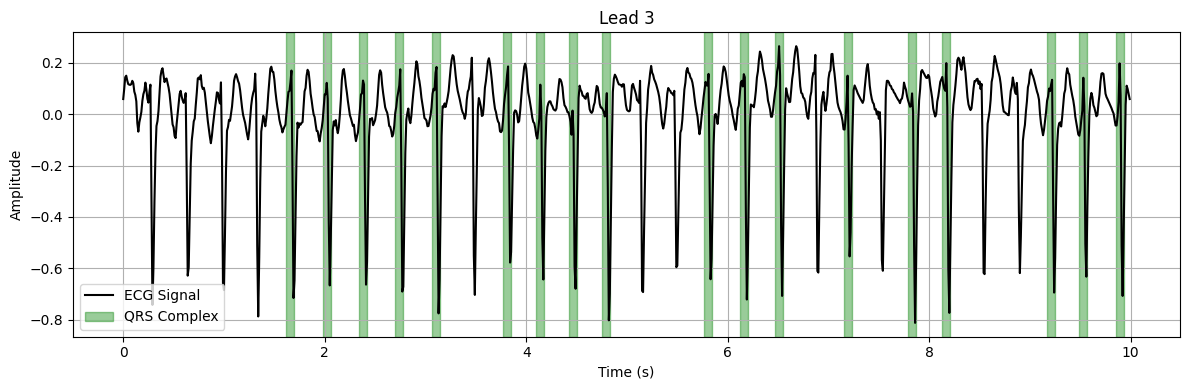

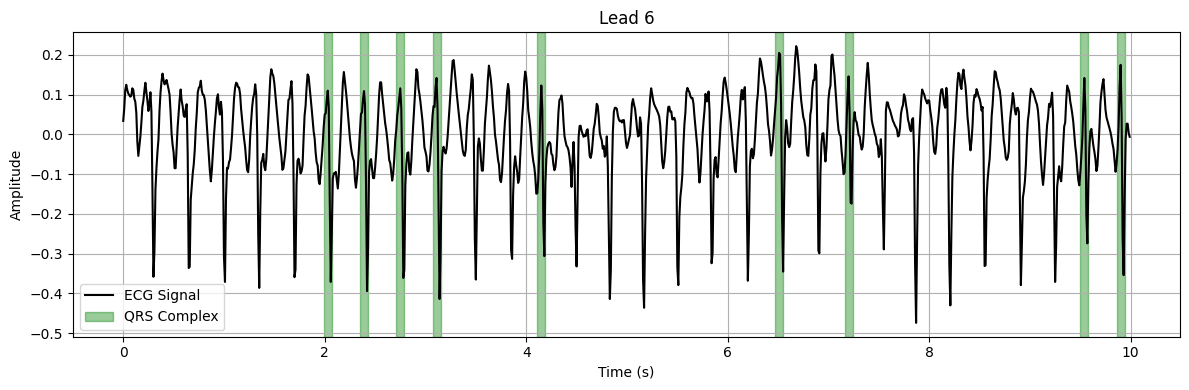

Blackboard_dataset/validation\validation03\validation03.npy → 1AVB

Lead 2 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)
  PQ = [160.0, 160.0, 160.0, 160.0, 160.0, 160.0, 160.0, 160.0] (ms)


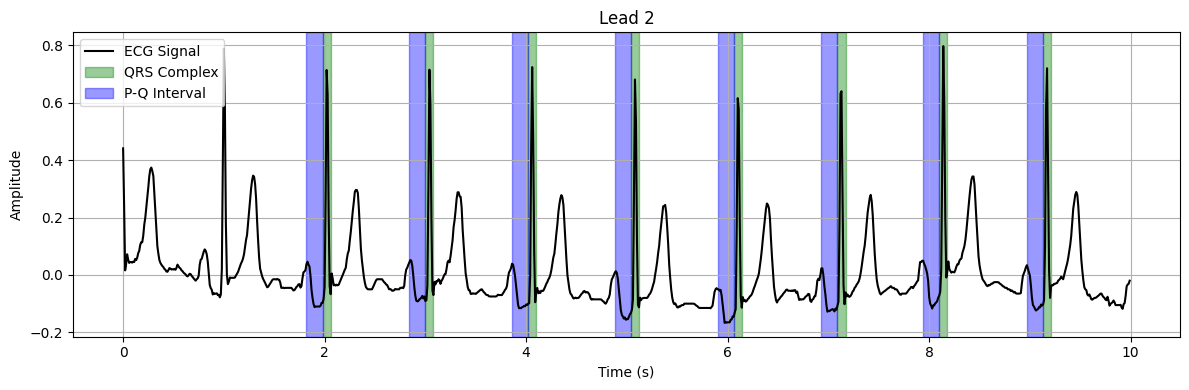

Blackboard_dataset/validation\validation04\validation04.npy → AFIB

Lead 2 durations:
  RR = [520.0, 390.0, 390.0, 490.0, 370.0, 500.0, 380.0, 360.0, 350.0, 460.0, 660.0, 510.0, 560.0, 350.0, 420.0, 380.0, 740.0, 470.0, 380.0, 460.0] (ms)
  Q_wave = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (ms)

Lead 7 durations:
  RR = [510.0, 400.0, 380.0, 490.0, 380.0, 490.0, 380.0, 360.0, 360.0, 460.0, 660.0, 500.0, 570.0, 340.0, 430.0, 370.0, 740.0, 470.0, 390.0, 450.0] (ms)
  Q_wave = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (ms)


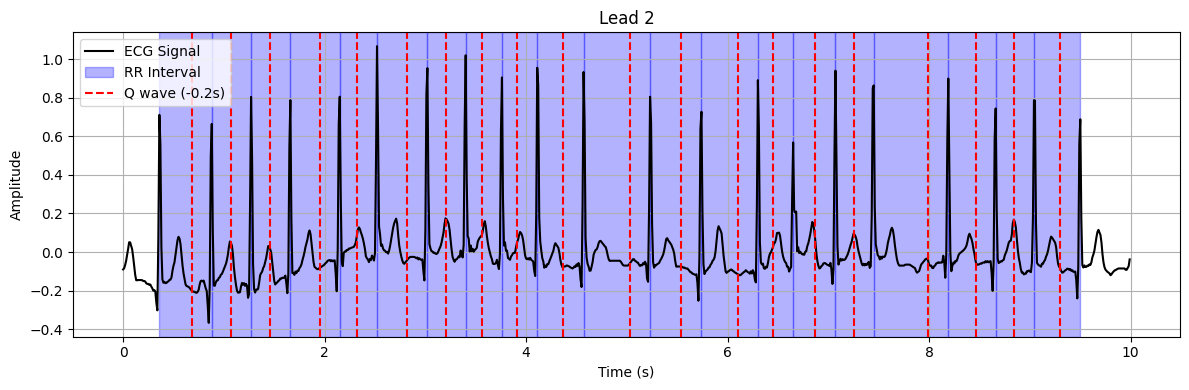

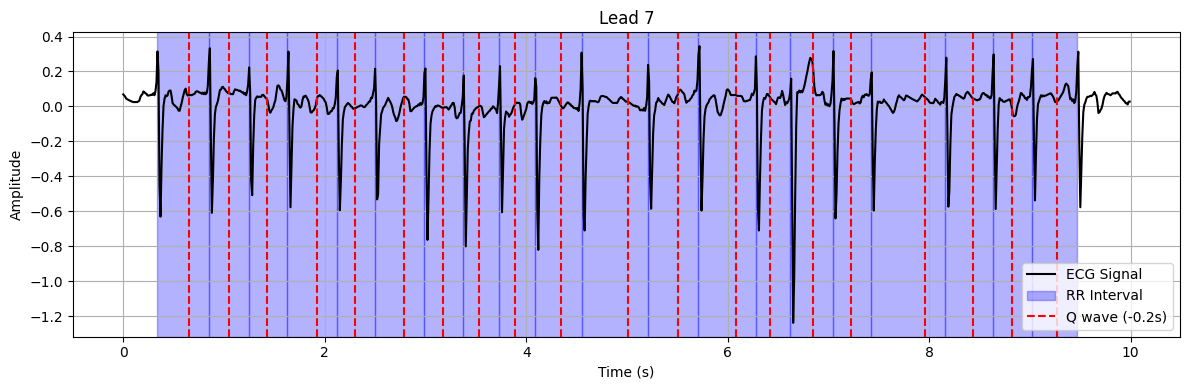

Blackboard_dataset/validation\validation05\validation05.npy → CRBBB

Lead 7 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)

Lead 8 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)


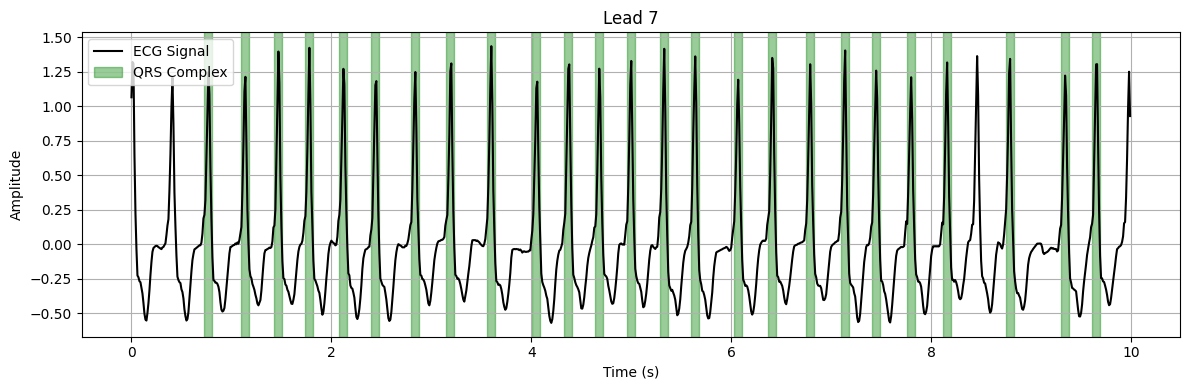

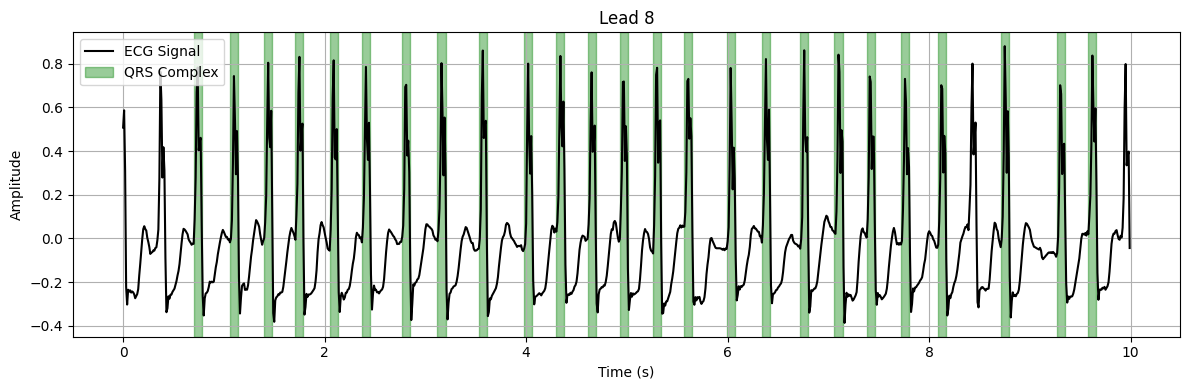

Blackboard_dataset/validation\validation06\validation06.npy → CLBBB

Lead 1 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)
  R_peak = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (ms)

Lead 11 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)
  R_peak = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (ms)

Lead 12 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)
  R_peak = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (ms)


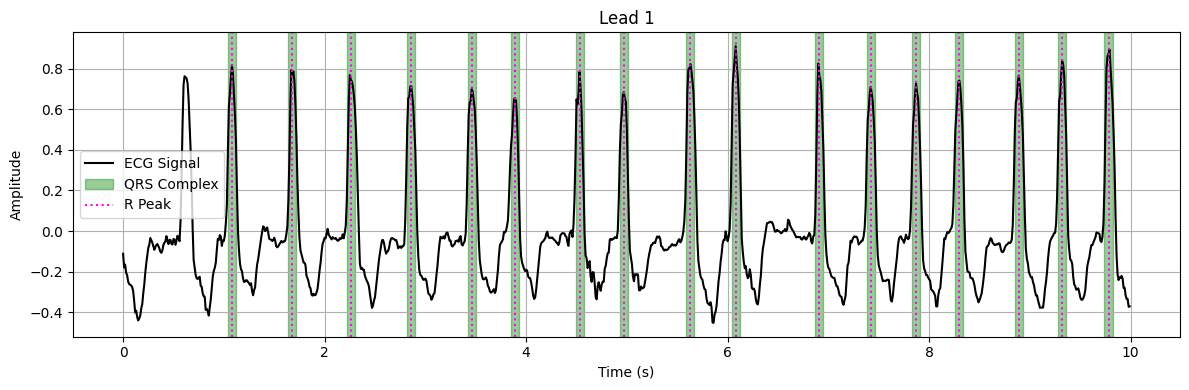

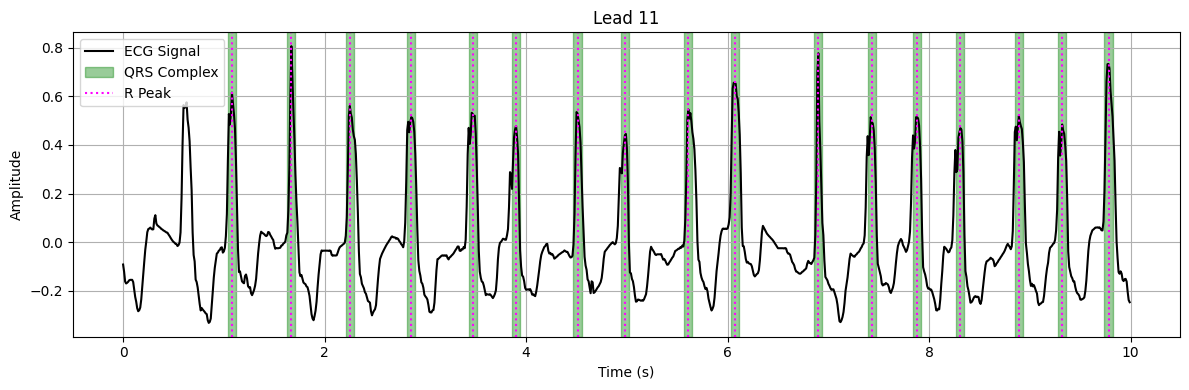

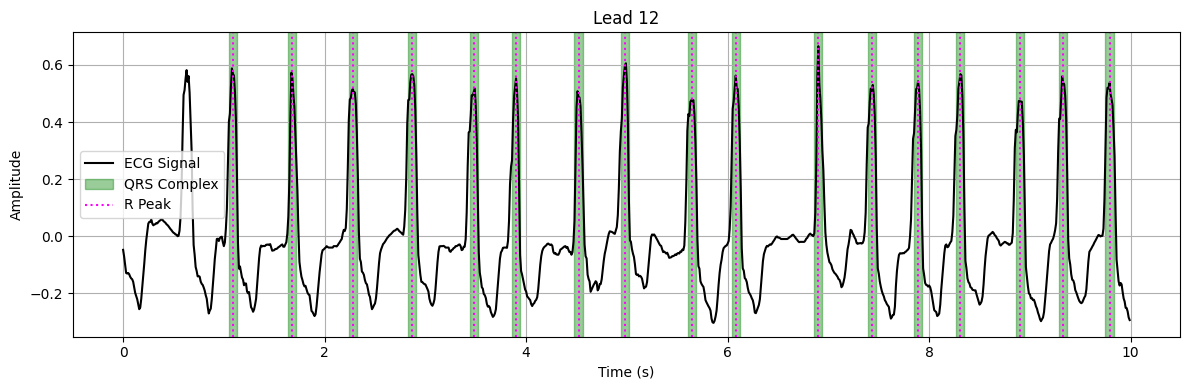

In [23]:
plot_key_ecg(result1)

Test dataset explanation

Blackboard_dataset/test\test01\test01.npy → 1AVB

Lead 2 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)
  PQ = [160.0, 160.0, 160.0, 160.0, 160.0, 160.0, 160.0, 160.0, 160.0] (ms)


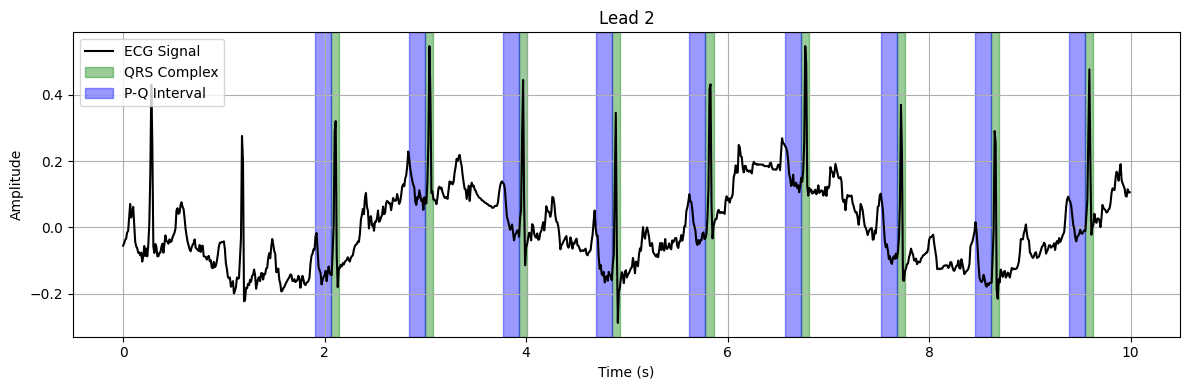

Blackboard_dataset/test\test02\test02.npy → CLBBB

Lead 1 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)
  R_peak = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (ms)

Lead 11 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)
  R_peak = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (ms)

Lead 12 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)
  R_peak = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (ms)


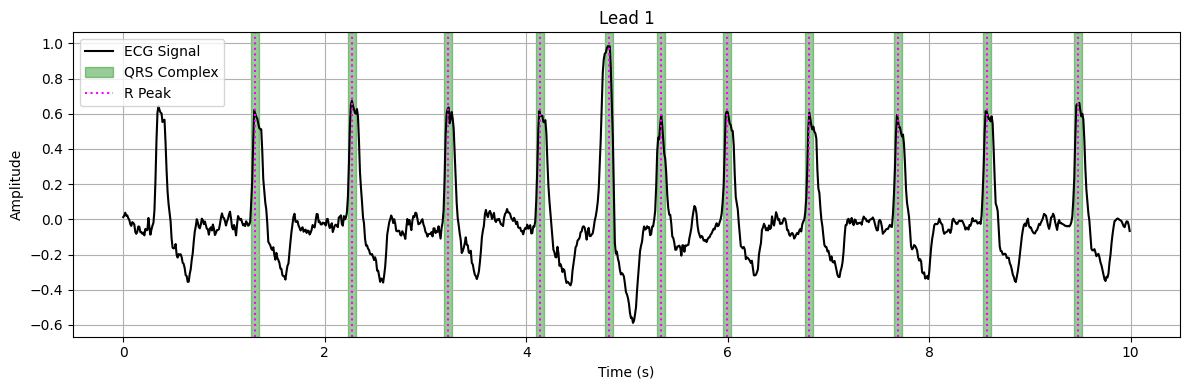

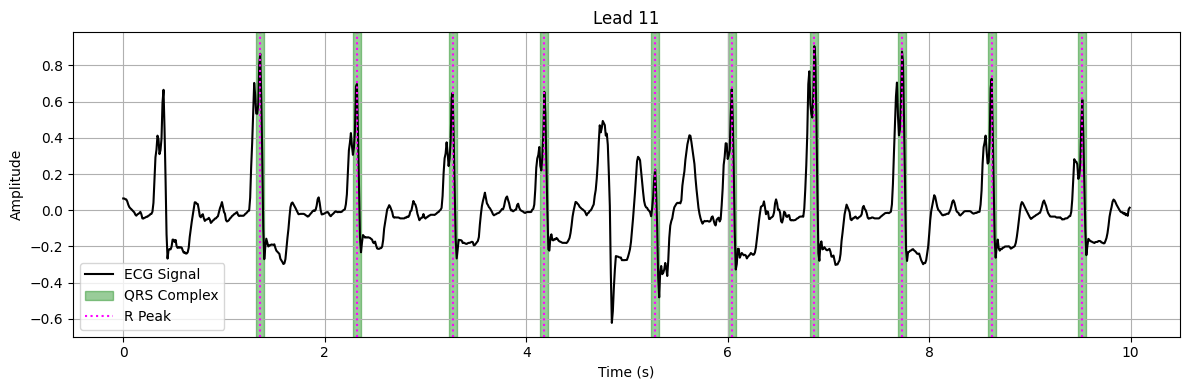

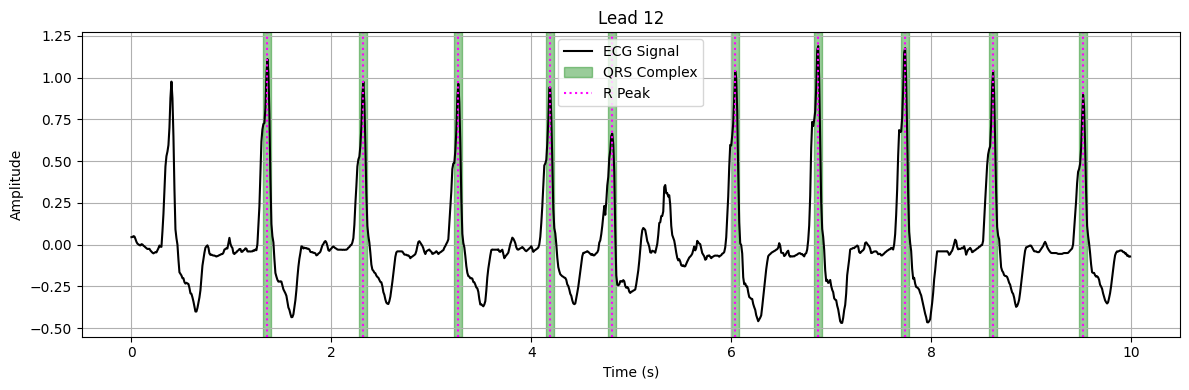

Blackboard_dataset/test\test03\test03.npy → NORM


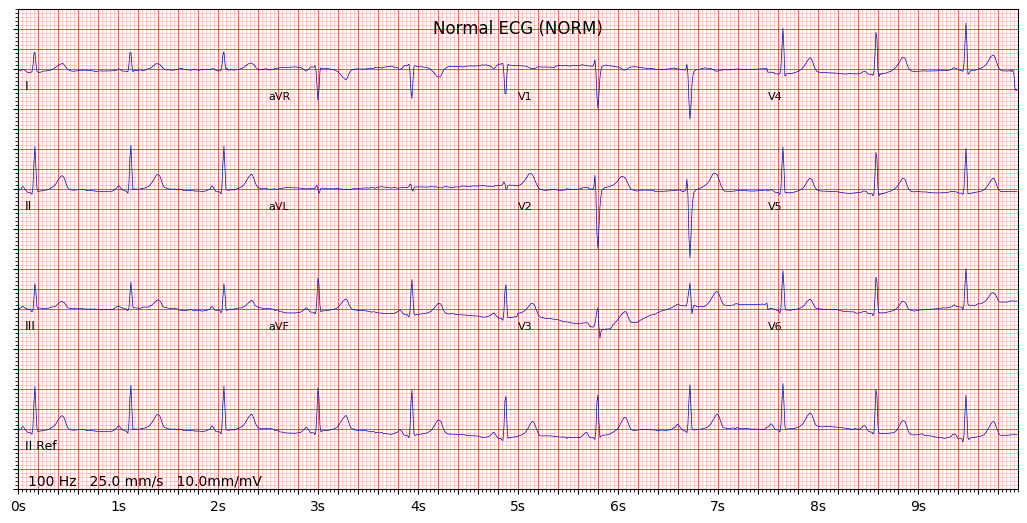

Blackboard_dataset/test\test04\test04.npy → AFLT

Lead 2 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)

Lead 3 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)

Lead 6 durations:
  QRS = [80.0, 80.0, 80.0] (ms)


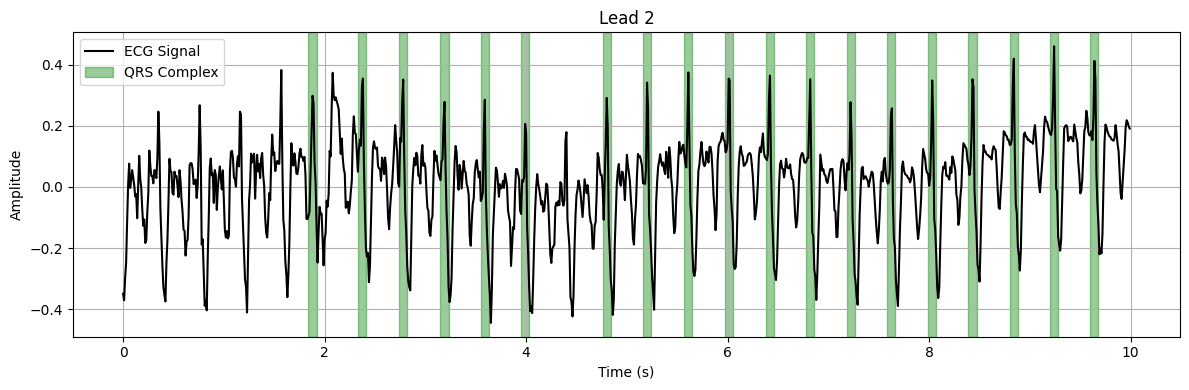

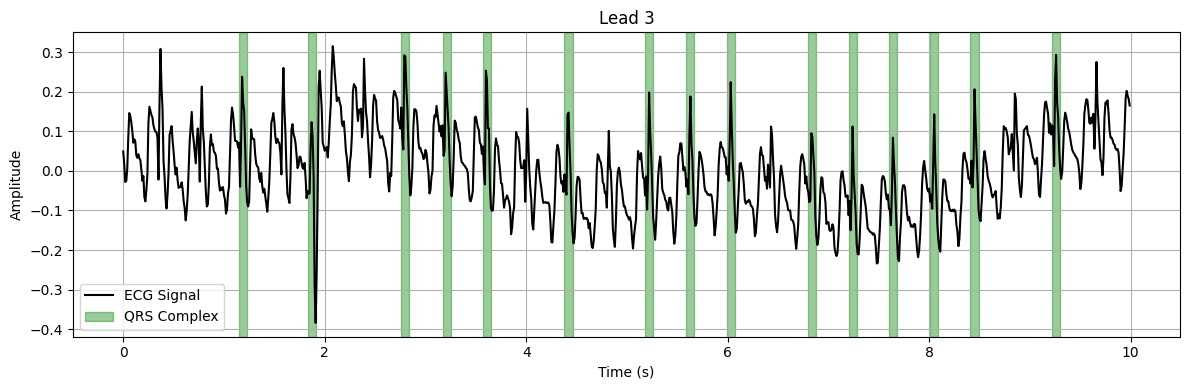

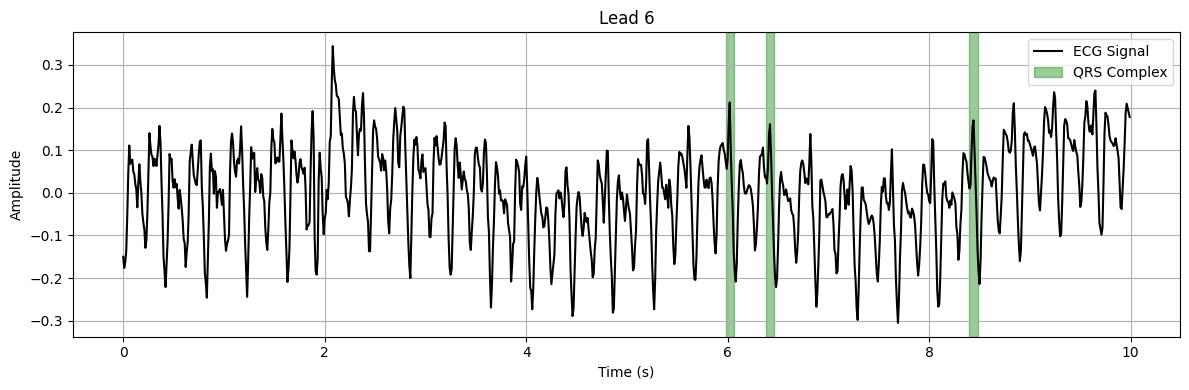

Blackboard_dataset/test\test05\test05.npy → AFIB

Lead 2 durations:
  RR = [420.0, 620.0, 520.0, 340.0, 370.0, 510.0, 420.0, 400.0, 420.0, 410.0, 520.0, 350.0, 390.0, 560.0, 400.0, 470.0, 430.0, 470.0, 480.0, 390.0] (ms)
  Q_wave = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (ms)

Lead 7 durations:
  RR = [410.0, 630.0, 520.0, 390.0, 370.0, 460.0, 410.0, 410.0, 490.0, 410.0, 520.0, 670.0, 560.0, 470.0, 470.0, 830.0, 870.0] (ms)
  Q_wave = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] (ms)


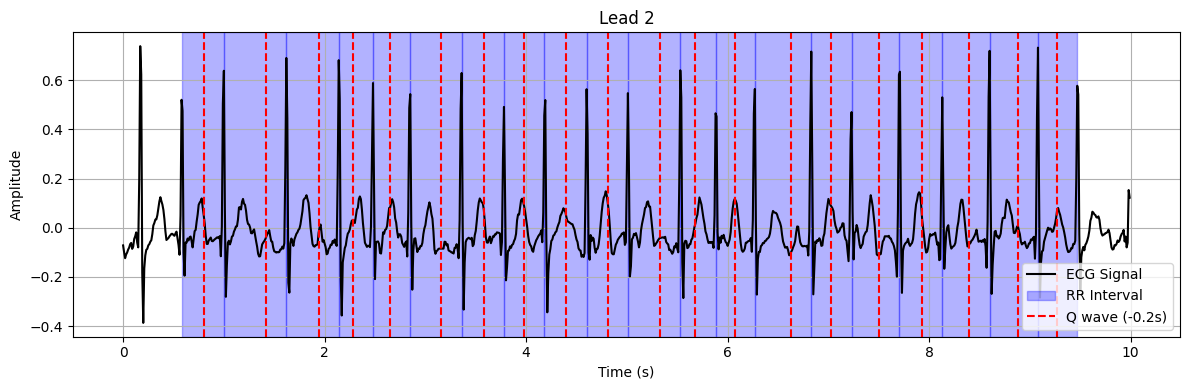

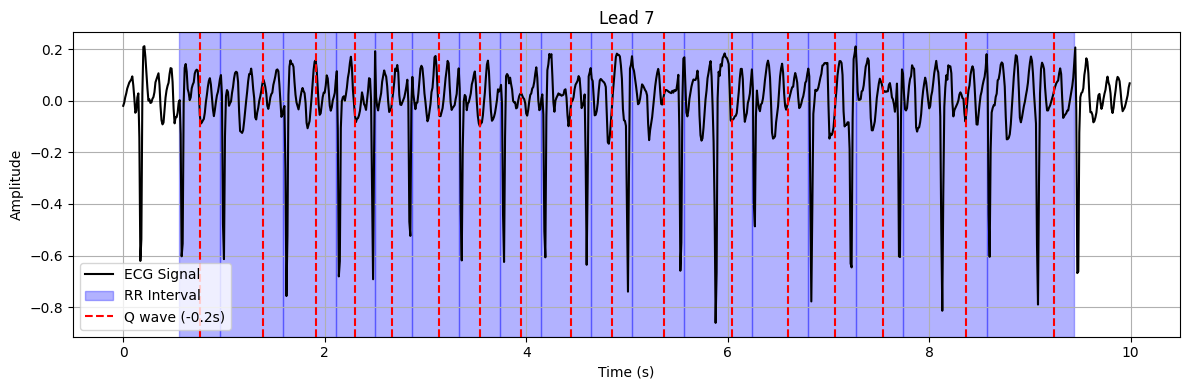

Blackboard_dataset/test\test06\test06.npy → CRBBB

Lead 7 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)

Lead 8 durations:
  QRS = [80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0] (ms)


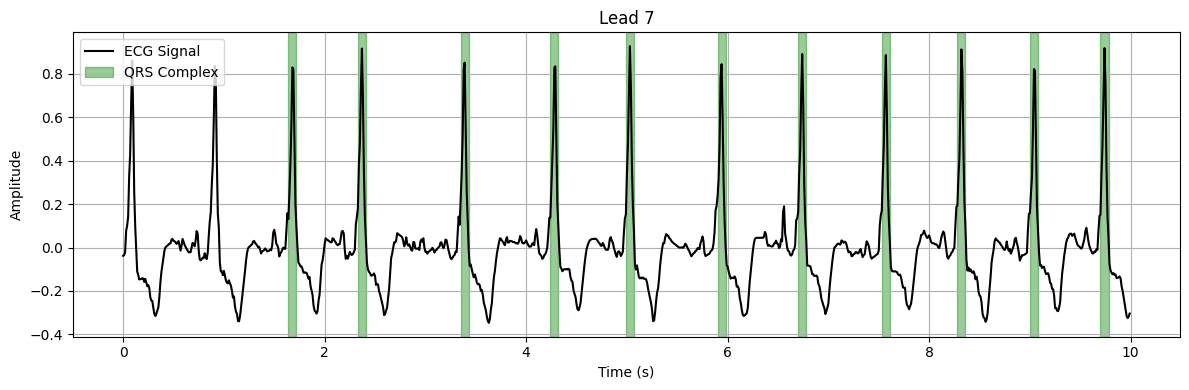

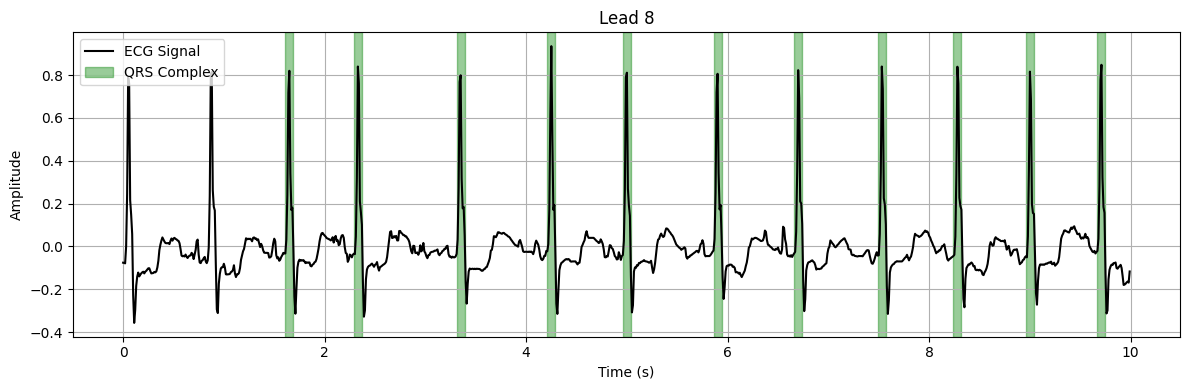

In [24]:
plot_key_ecg(result2)